## Build an anime recommender

In [59]:
import pandas as pd

animes = pd.read_csv('../data/anime.csv')
animes.dropna(axis=0, inplace=True)

animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [60]:
!unzip ../data/anime_rating.csv.zip anime_rating.csv -d ../data

ratings = pd.read_csv('../data/anime_rating.csv')

ratings.head()

Archive:  ../data/anime_rating.csv.zip
  inflating: ../data/anime_rating.csv  


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Popular-based recommender

To make it more sophisticated, we introduce you to the popular-based method with IMDB weighted rating.

Regarding the IMDB system, there are metrics called weighted rating systems used to score the rating of each movie.

Here is the formula of the weighted rating score.

`WR = (v ÷ (v + m)) × R + (m ÷ (v + m)) × C`

Where

1. `R` is the average rating for the item.
1. `v` is the number of votes for the item.
1. `m` is the minimum votes required to be listed in the popular items(defined by > percentile 80 of total votes)
1. `C` is the average rating across the whole dataset.

In [43]:
import numpy as np

def weighted_rating(R: float, v: float, m: pd.Series, C: pd.Series):
    '''
    Calculate the weighted rating
    
    Parameters
    ----------
    v : float
        average rating for each item.
    m : float
        minimum votes required to be classified as popular.
    R : pd.Series
        average rating for the item.
    C : pd.Series
        average rating for the whole dataset.
    
    Returns
    -------
    pd.Series
    '''

    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )


def assign_popular_based_score(
    rating_df: pd.DataFrame, item_df: pd.DataFrame,
    user_col, item_col, rating_col
):
    '''
    Assigned popular based score based on the IMDB weighted average.
    
    Parameters
    ----------
    rating_df : pd.DataFrame
        contains ['item_id', 'rating'] for each user.
    
    Returns
    -------
    popular_items : pd.DataFrame
        contains item and IMDB weighted score.
    '''
    
    vote_count = rating_df.groupby(item_col, as_index=False) \
        .agg({user_col: 'count', rating_col: 'mean'})
    vote_count.columns = [item_col, 'vote_count', 'avg_rating']

    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(R, v, m, C)

    vote_count = vote_count.merge(item_df, on=[item_col], how='left')
    popular_items = vote_count.loc[:,[item_col, 'genre', 'vote_count', 'avg_rating', 'weighted_rating']]

    return popular_items

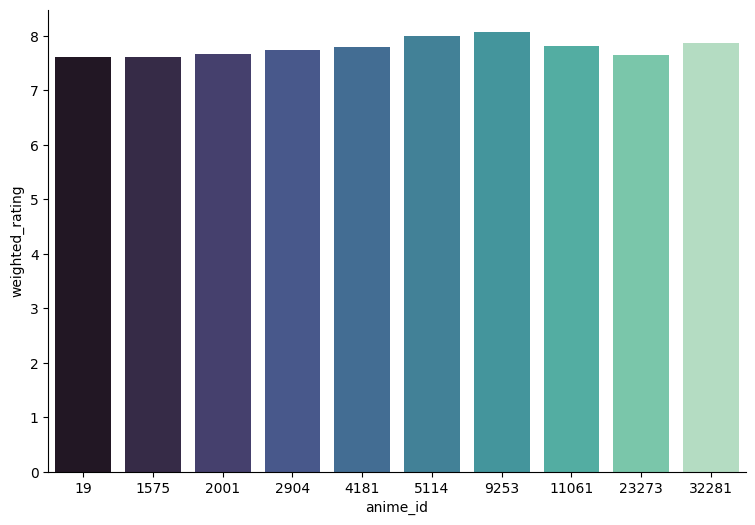

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

USER_COL = 'user_id'
ITEM_COL = 'anime_id'
RATING_COL = 'rating'

# calcualte popularity based
popular_items = assign_popular_based_score(ratings, animes, USER_COL, ITEM_COL, RATING_COL)
popular_items = popular_items.sort_values('weighted_rating', ascending=False)

fix, ax = plt.subplots(figsize=(9, 6))
sns.barplot(
    data=popular_items.head(10),
    x='anime_id', y='weighted_rating',
    palette='mako'
)
sns.despine()

## Content-based recommender

In [20]:
rated_items = animes.loc[animes['anime_id'].isin(ratings['anime_id'])].copy()

rated_items.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [23]:
genres = rated_items['genre'].str.split(',', expand=True)

genres.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Drama,Romance,School,Supernatural,None,None,None,None,None,None,None,None,None
1,Action,Adventure,Drama,Fantasy,Magic,Military,Shounen,None,None,None,None,None,None
2,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None
3,Sci-Fi,Thriller,None,None,None,None,None,None,None,None,None,None,None
4,Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen,None,None,None,None,None,None


In [24]:
all_genres = set()
for c in genres.columns:
    distinct_genres = genres[c].str.lower().str.strip().unique()
    all_genres.update(distinct_genres)
all_genres.remove(None)

all_genres

{'action',
 'adventure',
 'cars',
 'comedy',
 'dementia',
 'demons',
 'drama',
 'ecchi',
 'fantasy',
 'game',
 'harem',
 'hentai',
 'historical',
 'horror',
 'josei',
 'kids',
 'magic',
 'martial arts',
 'mecha',
 'military',
 'music',
 'mystery',
 'parody',
 'police',
 'psychological',
 'romance',
 'samurai',
 'school',
 'sci-fi',
 'seinen',
 'shoujo',
 'shoujo ai',
 'shounen',
 'shounen ai',
 'slice of life',
 'space',
 'sports',
 'super power',
 'supernatural',
 'thriller',
 'vampire',
 'yaoi',
 'yuri'}

In [39]:
import numpy as np

item_genre_mat = rated_items[['anime_id', 'genre']].copy()
item_genre_mat['genre'] = item_genre_mat['genre'].str.lower().str.strip()

for genre in all_genres:
    item_genre_mat[genre] = np.where(item_genre_mat['genre'].str.contains(genre), 1, 0)
item_genre_mat.drop(['genre'], axis=1, inplace=True)
item_genre_mat.set_index('anime_id', inplace=True)

item_genre_mat.head()

,action,dementia,romance,hentai,school,mecha,vampire,mystery,shounen ai,parody,...,police,supernatural,psychological,historical,super power,space,josei,demons,magic,drama
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5114,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
28977,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9969,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

# compute similarity matix
corr_mat = cosine_similarity(item_genre_mat)

# get top-k similar items
idx2name = {idx: name for idx, name in enumerate(item_genre_mat.index)}
name2idx = {name: idx for idx, name in idx2name.items()}

def top_k_items(item_id: int, top_k: int, corr_mat: np.ndarray, map_name: dict):
    
    # sort correlation value ascendingly and select top_k item_id
    top_items = corr_mat[item_id, :].argsort()[-top_k:][::-1] 
    top_items = [map_name[e] for e in top_items] 

    return top_items

similar_items = top_k_items(
    name2idx[99], top_k=10, corr_mat=corr_mat, map_name=idx2name
)

# display result
print("The top-k similar animes to anime_id 99")
animes.loc[animes['anime_id'].isin(similar_items)]

The top-k similar movie to anime_id 99


,anime_id,name,genre,type,episodes,rating,members
969,371,Cardcaptor Sakura Movie 1,"Comedy, Drama, Fantasy, Magic, Shoujo",Movie,1,7.74,56327
1937,99,Mai-Otome,"Comedy, Drama, Fantasy, Magic",TV,26,7.40,36924
2886,1659,Mai-Otome Specials,"Comedy, Drama, Fantasy, Magic",Special,9,7.14,4609
3803,10098,Kobato.: Hajimete no Kobato.,"Comedy, Drama, Fantasy",Special,8,6.88,6001
4911,1807,Prism Ark,"Action, Comedy, Drama, Fantasy, Magic",TV,12,6.60,16596
5579,17681,Zettai Bouei Leviathan,"Comedy, Fantasy, Magic",TV,13,6.42,18202
5955,4566,Prism Ark Specials,"Action, Comedy, Drama, Fantasy, Magic",Special,6,6.30,1636
6272,1990,Mahou Gakuen Lunar! Aoi Ryuu no Himitsu,"Comedy, Fantasy, Magic",Movie,1,6.19,833
6504,19397,Zettai Bouei Leviathan: Mini Takibi Gekijou,"Comedy, Fantasy, Magic",Special,13,6.09,1203
7275,3597,Fantasia,"Comedy, Drama, Fantasy, Magic, Romance",OVA,1,5.58,877


In [58]:
import gc

del corr_mat
gc.collect()

705885